#### Library

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
import datetime
w.filterwarnings('ignore')

#### Dataset

In [3]:
train = pd.read_csv('D:\Fahmi\AI-data\ML\Predict-calorie-expenditures\calorie_expenditure_regression\input\\train.csv')
test = pd.read_csv('D:\Fahmi\AI-data\ML\Predict-calorie-expenditures\calorie_expenditure_regression\input\\test.csv')

#### Dataset info

In [4]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [5]:
print('\nTraining data info :')
train.info()
print('\nTest data info :')
test.info()
print('\nMissing values in train data :')
print(train.isnull().sum())
print('\nMissing values in test data :')
print(test.isnull().sum())


Training data info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB

Test data info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   

In [10]:
print('Summary statistic of numerical column')
train.describe().T

Summary statistic of numerical column


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


#### EDA
There is no need to preprocess the data because the dataset is neat, structured, has no null values, and each data is unique

Almost all data is normally distributed

There are 3 features that have a large contribution in the dataset, namely duration, heart rate, and body temperature

In [11]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train.select_dtypes(include=['object', 'category']).columns

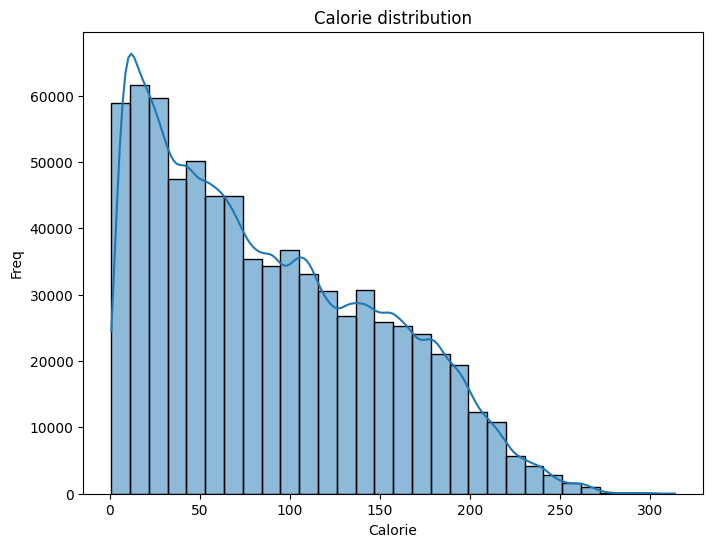

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(train, x='Calories', kde=True, bins=30)
plt.title('Calorie distribution')
plt.xlabel('Calorie')
plt.ylabel('Freq')
plt.show()

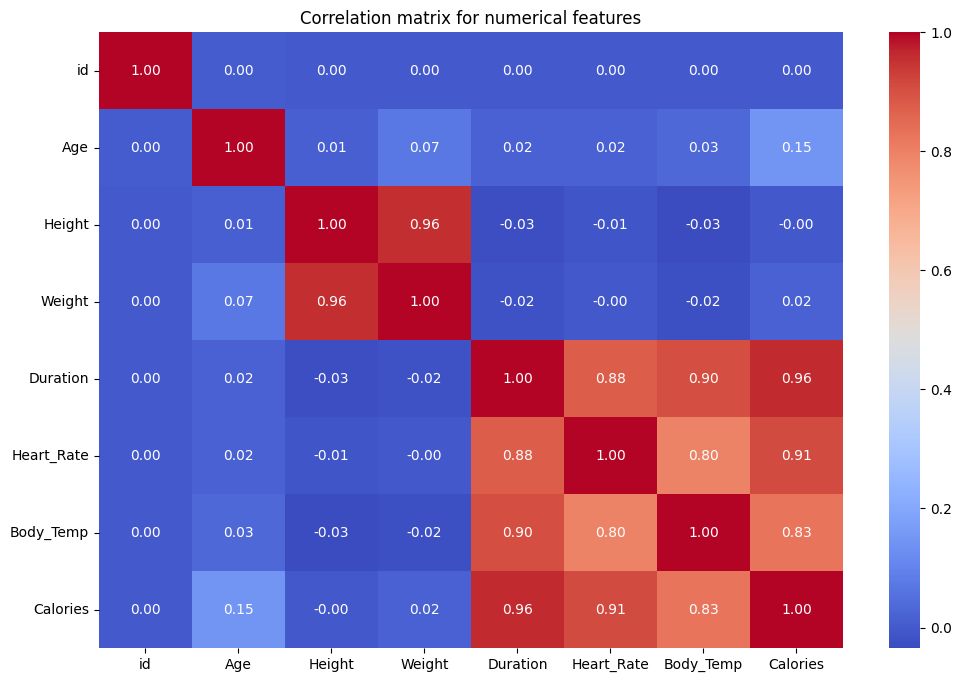

In [13]:
plt.figure(figsize=(12, 8))
corr_matrix = train[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix for numerical features')
plt.show()

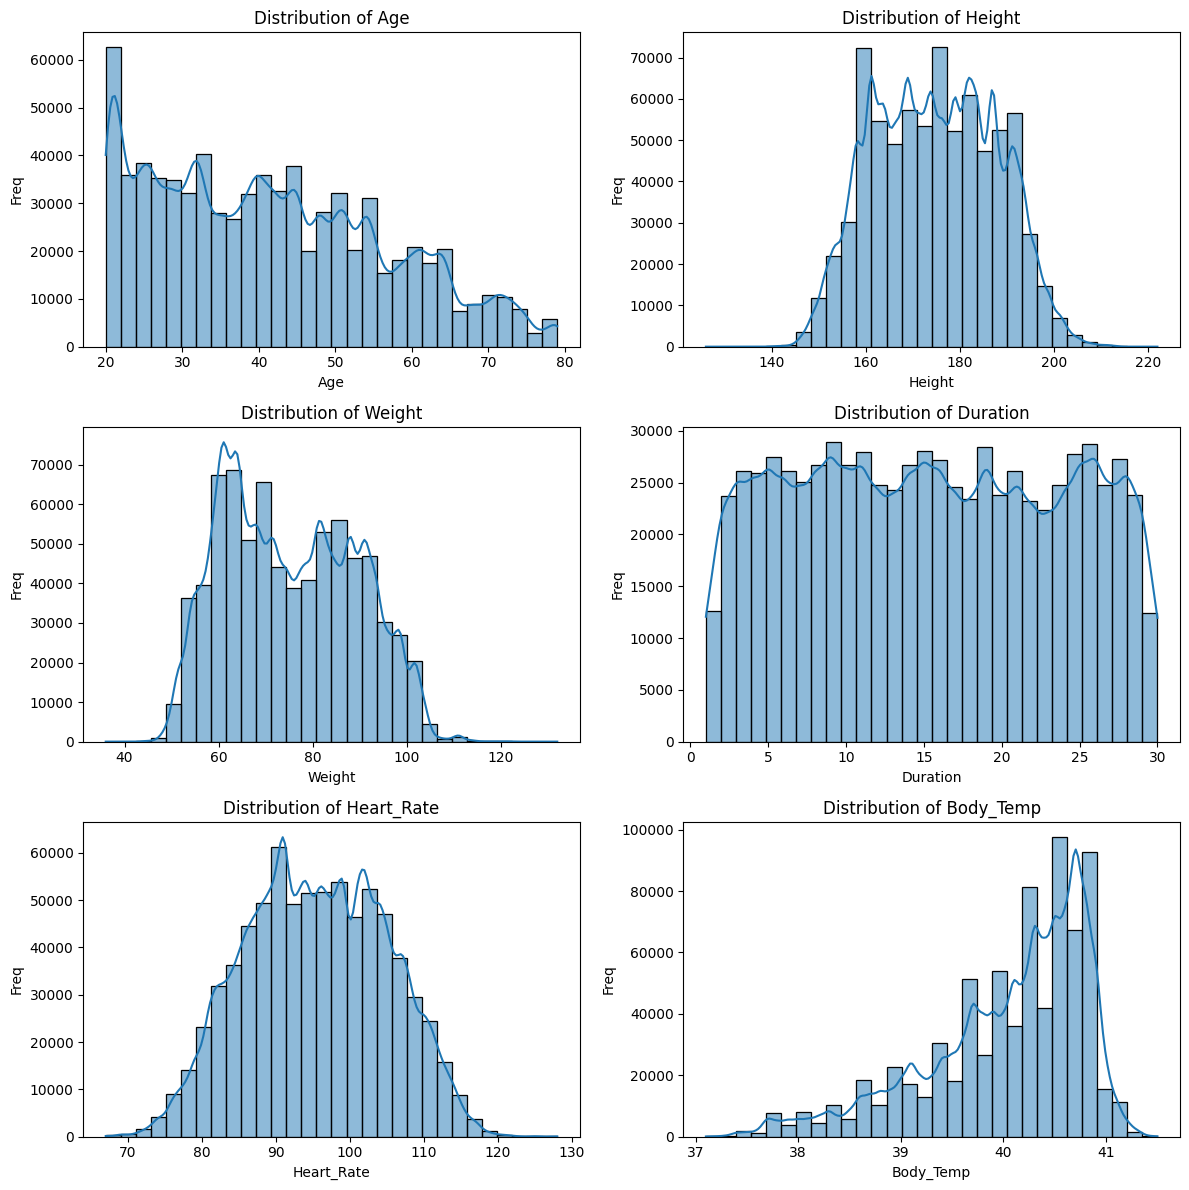

In [14]:
num_dist_plot = [col for col in num_cols if col != 'Calories' and col != 'id']
n_cols = 2
n_rows = (len(num_dist_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_dist_plot):
    sns.histplot(train, x=col, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Freq')
    
for i in range(len(num_dist_plot), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

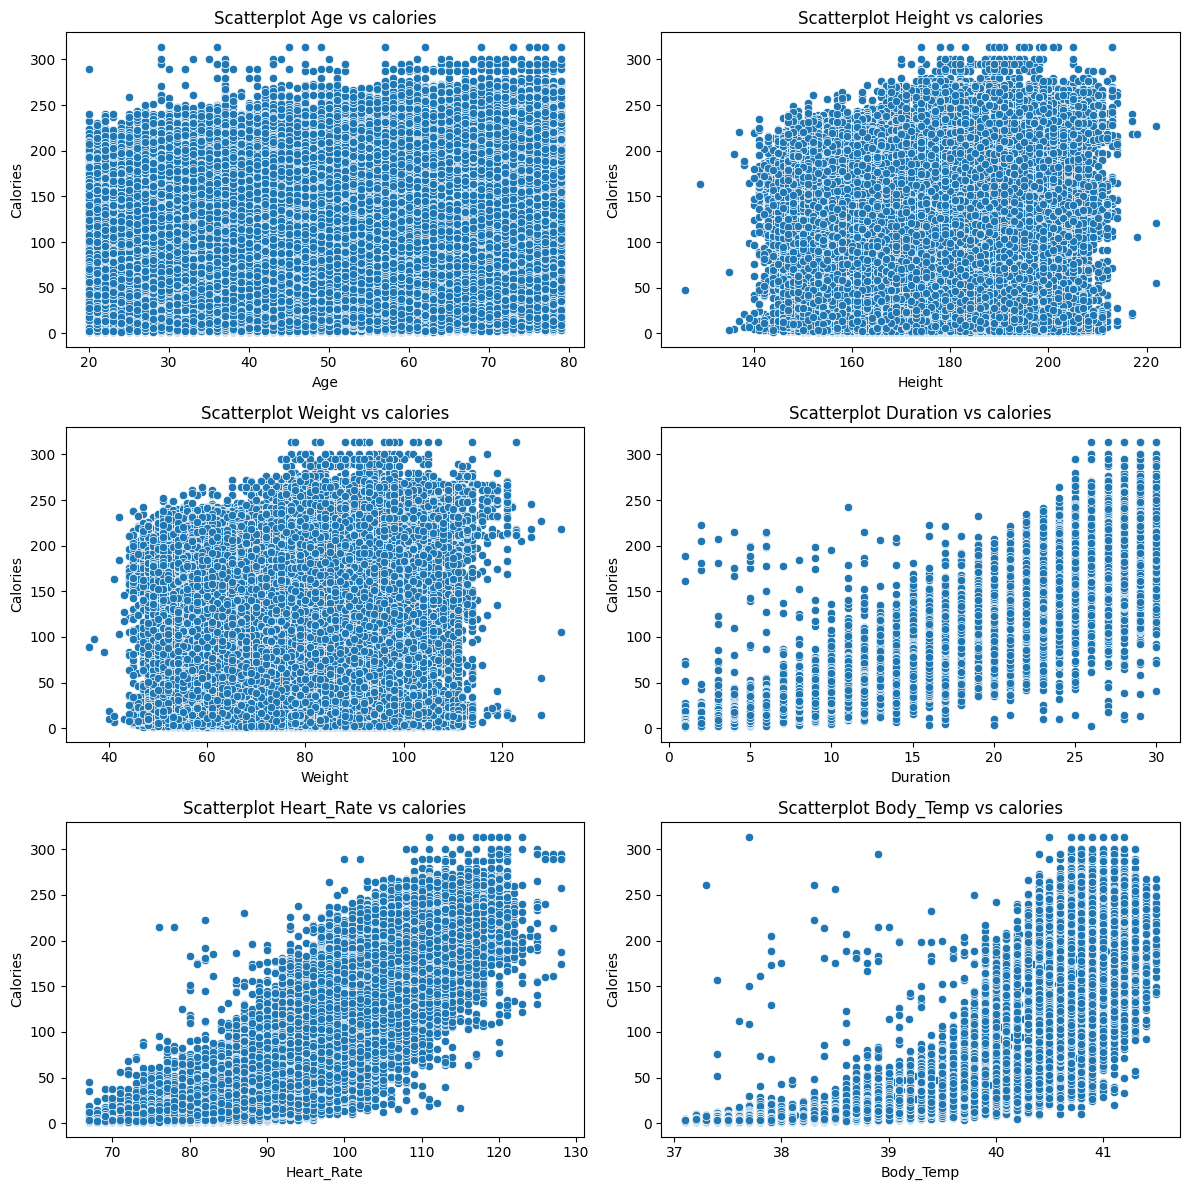

In [15]:
num_dist_plot = [col for col in num_cols if col != 'Calories' and col != 'id']
n_cols = 2
n_rows = (len(num_dist_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_dist_plot):
    sns.scatterplot(train, x=col, y='Calories', ax=axes[i])
    axes[i].set_title(f'Scatterplot {col} vs calories')
    
for i in range(len(num_dist_plot), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

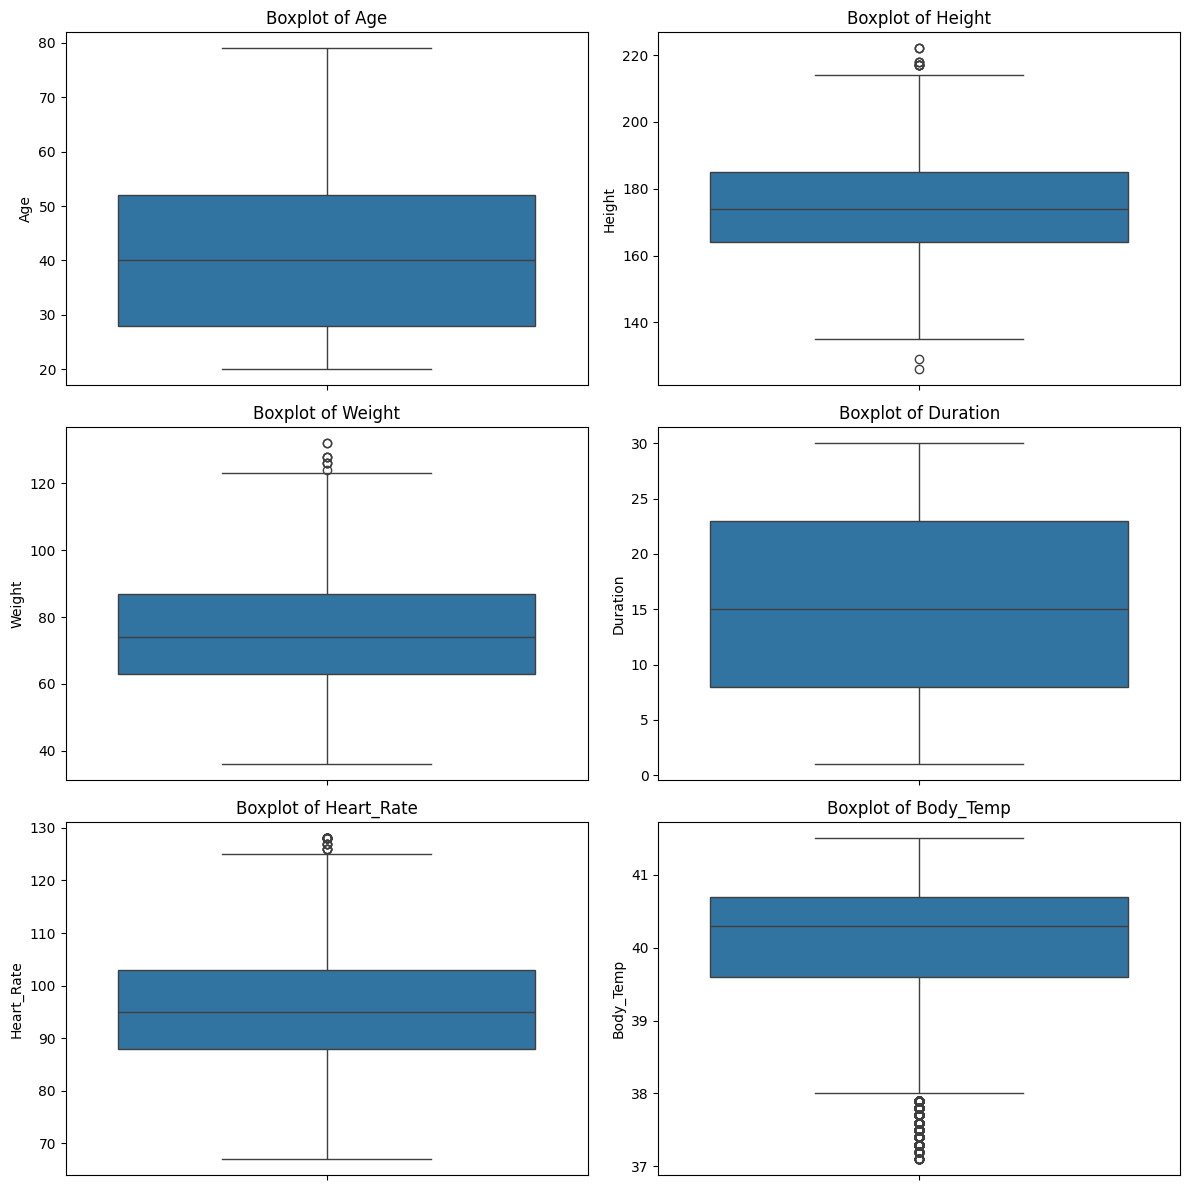

In [16]:
num_dist_plot = [col for col in num_cols if col != 'Calories' and col != 'id']
n_cols = 2
n_rows = (len(num_dist_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_dist_plot):
    sns.boxplot(train, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)
    axes[i].set_xlabel('')
    
for i in range(len(num_dist_plot), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

#### Feature engineering

In [17]:
# Weight_per_Age
train['Weight_per_Age'] = train['Weight'] / (train['Age'] + 1)
test['Weight_per_Age'] = test['Weight'] / (test['Age'] + 1)

# HeartRate per Weight
train['HeartRate_per_kg'] = train['Heart_Rate'] / train['Weight']
test['HeartRate_per_kg'] = test['Heart_Rate'] / test['Weight']
# Duration Per Age
train['Duration_per_age'] = train['Duration'] / (train['Age'] + 1)
test['Duration_per_age'] = test['Duration'] / (test['Age'] + 1 )

# Duration * Heart Rate
train['Duration_heart_rate']=train['Duration']*train['Heart_Rate']
test['Duration_heart_rate']=test['Duration']*test['Heart_Rate']

# Intensity
train['Duration_per_weight']=train['Duration']/train['Weight']
test['Duration_per_weight']=test['Duration']/test['Weight']

# All Durations add and multi
train['duration_sum']=train['Duration_per_weight']+train['Duration_heart_rate']+train['Duration_per_age']
test['duration_sum']=test['Duration_per_weight']+test['Duration_heart_rate']+test['Duration_per_age']

train['duration_multi']=train['Duration_per_weight']*train['Duration_heart_rate']*train['Duration_per_age']
test['duration_multi']=test['Duration_per_weight']*test['Duration_heart_rate']*test['Duration_per_age']

# Converting Height in Meters
train['Height']=train['Height']/100
test['Height']=test['Height']/100

# Creating new column 'BMI'
train['BMI']=train['Weight']/(train['Height'] ** 2)
train['BMI']=train['BMI'].round(2)
test['BMI']=test['Weight']/(test['Height'] ** 2)
test['BMI']=test['BMI'].round(2)

# Mapping Genders
map={'male':0,'female':1}
train['Sex']=train['Sex'].map(map)
test['Sex']=test['Sex'].map(map)

#### Tuning hyperparameter model

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

X = train.drop(columns=['id', 'Calories'])
y = train['Calories']

def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    params = {
        'tree_method': 'hist',
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    preds_clip = np.maximum(0, preds)
    rmsle = np.sqrt(mean_squared_log_error(y_val, preds_clip))
    
    return rmsle

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
    
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
filename = "optuna_tuning_log.txt"

with open(filename, "a") as f:
    f.write("="*50 + "\n")
    f.write(f"Tuning Timestamp: {timestamp}\n")
    f.write("Best RMSE: {:.5f}\n".format(study.best_value))
    f.write("Best Parameters:\n")
    for key, value in study.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write("="*50 + "\n\n")

#### Predict

In [ ]:
best_params = study.best_params

best_params.update({
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1,
    'n_estimators': 1000,
})

final_model = XGBRegressor(**best_params)
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6332097368693999, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.3841072597639574, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.009456490533119234,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
xgb_model = XGBRegressor({
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1,
    'n_estimators': 1000,
    'learning_rate': 0.009456490533119234,
    'max_depth': 10,
    'reg_lambda': 1.7434697249357467,
    'reg_alpha': 0.6488287215083401,
    'subsample': 0.9494258651834557,
    'colsample_bytree': 0.6332097368693999,
    'min_child_weight': 6,
    'gamma': 0.3841072597639574
})

xgb_model.fit(X, y)

#### Save submission

In [ ]:
submission = pd.read_csv("D:\Fahmi\AI-data\ML\Predict-calorie-expenditures\calorie_expenditure_regression\input\sample_submission.csv")
X_test = test.drop(columns=['id'])

preds = final_model.predict(X_test)
assert len(preds) == len(submission), "Jumlah prediksi dan ID tidak cocok!"
submission['Calories'] = preds
submission.to_csv('submission1.csv', index=False)